In [19]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, f1_score
from scipy.sparse import vstack
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Load dataset
train_df = pd.read_csv("data/processed_train.csv").dropna(subset=["clean_headline"])
val_df = pd.read_csv("data/processed_val.csv").dropna(subset=["clean_headline"])
test_df = pd.read_csv("data/processed_test.csv").dropna(subset=["clean_headline"])

X_train, y_train = train_df["clean_headline"], train_df["label_encoded"]
X_val, y_val = val_df["clean_headline"], val_df["label_encoded"]
X_test, y_test = test_df["clean_headline"], test_df["label_encoded"]

In [20]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
import numpy as np
import os

os.makedirs("models/results", exist_ok=True)
os.makedirs("models/plots", exist_ok=True)

vectorizers = {
    "BoW": CountVectorizer(),
    "TF-IDF Bigrams": TfidfVectorizer(ngram_range=(1, 2)),
    "TF-IDF Sublinear": TfidfVectorizer(sublinear_tf=True),
    "Char TF-IDF": TfidfVectorizer(analyzer="char", ngram_range=(2, 5), min_df=2)
}

C_values = [0.01, 0.1, 1, 10]
results = {}

for name, vectorizer in vectorizers.items():
    print(f"\n🔍 Vectorizer: {name}")
    X_train_vec = vectorizer.fit_transform(X_train)
    X_val_vec = vectorizer.transform(X_val)
    val_f1s = []

    for C in C_values:
        clf = LogisticRegression(C=C, penalty="l2", solver="liblinear", max_iter=1000)
        clf.fit(X_train_vec, y_train)
        val_pred = clf.predict(X_val_vec)
        f1 = f1_score(y_val, val_pred)
        val_f1s.append(f1)
        print(f"  C={C:<5} → Val F1 Score: {f1:.4f}")

    results[name] = (vectorizer, val_f1s)

    # 🔍 Save F1 Scores
    df_f1 = pd.DataFrame({"C": C_values, "Val_F1": val_f1s})
    df_f1.to_csv(f"models/results/val_f1_{name.replace(' ', '_')}.csv", index=False)

    # ✅ Get best C
    best_idx = np.argmax(val_f1s)
    best_C = C_values[best_idx]
    print(f"✅ Best C for {name}: {best_C} (Val F1 = {val_f1s[best_idx]:.4f})")

    # 🔍 Show top features
    clf_best = LogisticRegression(C=best_C, penalty="l2", solver="liblinear", max_iter=1000)
    clf_best.fit(X_train_vec, y_train)
    feature_names = vectorizer.get_feature_names_out()
    coefs = clf_best.coef_[0]

    top_indices = np.argsort(np.abs(coefs))[::-1][:15]
    top_features = [(feature_names[i], coefs[i]) for i in top_indices]

    print("🧠 Top 15 Features:")
    for feat, weight in top_features:
        print(f"{feat:25s} → {weight:+.4f}")

    # 💾 Save to text file
    with open(f"models/results/top_features_{name.replace(' ', '_')}.txt", "w") as f:
        for feat, weight in top_features:
            f.write(f"{feat:25s} → {weight:+.4f}\n")


🔍 Vectorizer: BoW
  C=0.01  → Val F1 Score: 0.8251
  C=0.1   → Val F1 Score: 0.8817
  C=1     → Val F1 Score: 0.9102
  C=10    → Val F1 Score: 0.9134
✅ Best C for BoW: 10 (Val F1 = 0.9134)
🧠 Top 15 Features:
coronavirus               → +8.1143
pahalgam                  → -7.6312
truth                     → +7.4666
corona                    → +6.6547
covid                     → +6.5968
finland                   → +6.5821
livessubscriber           → -6.4729
trumpsubscriber           → -6.1980
babil                     → -6.1275
lockdown                  → +5.9609
misrepresent              → +5.9182
jnu                       → +5.8578
misinformation            → +5.7676
photoshoppe               → +5.7193
delimitation              → -5.5966

🔍 Vectorizer: TF-IDF Bigrams
  C=0.01  → Val F1 Score: 0.5994
  C=0.1   → Val F1 Score: 0.8409
  C=1     → Val F1 Score: 0.9008
  C=10    → Val F1 Score: 0.9215
✅ Best C for TF-IDF Bigrams: 10 (Val F1 = 0.9215)
🧠 Top 15 Features:
video               

In [1]:
import os
import pandas as pd
import numpy as np
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# -------------------------------
# 📂 Paths
# -------------------------------
RESULT_DIR = "models/results"
ARTIFACT_DIR = "models/lr/artifacts"
os.makedirs(ARTIFACT_DIR, exist_ok=True)

# -------------------------------
# 🔍 Scan val_f1 CSVs to Find Best C + Vectorizer
# -------------------------------
best_score = 0
best_vectorizer_name = None
best_C = None

for fname in os.listdir(RESULT_DIR):
    if fname.startswith("val_f1_") and fname.endswith(".csv"):
        df = pd.read_csv(os.path.join(RESULT_DIR, fname))
        vec_name = fname.replace("val_f1_", "").replace(".csv", "").replace("_", " ")

        idx = df["Val_F1"].idxmax()
        top_f1 = df.loc[idx, "Val_F1"]
        top_c = df.loc[idx, "C"]

        if top_f1 > best_score:
            best_score = top_f1
            best_C = top_c
            best_vectorizer_name = vec_name

print(f"🏆 Best LR Config: {best_vectorizer_name}, C={best_C}, Val_F1={best_score:.4f}")

# -------------------------------
# 📦 Load Training Data
# -------------------------------
train_df = pd.read_csv("data/processed_train.csv").dropna(subset=["clean_headline", "label_encoded"])
X_train = train_df["clean_headline"].astype(str)
y_train = train_df["label_encoded"]

# -------------------------------
# 🔠 Create Vectorizer
# -------------------------------
vec_map = {
    "BoW": CountVectorizer(),
    "TF-IDF Bigrams": TfidfVectorizer(ngram_range=(1, 2)),
    "TF-IDF Sublinear": TfidfVectorizer(sublinear_tf=True),
    "Char TF-IDF": TfidfVectorizer(analyzer="char", ngram_range=(2, 5), min_df=2)
}

vectorizer = vec_map[best_vectorizer_name]
X_train_vec = vectorizer.fit_transform(X_train)

# -------------------------------
# 🧠 Train Final Model
# -------------------------------
clf = LogisticRegression(C=best_C, penalty="l2", solver="liblinear", max_iter=1000)
clf.fit(X_train_vec, y_train)

# -------------------------------
# 💾 Save Model + Vectorizer
# -------------------------------
joblib.dump(clf, f"{ARTIFACT_DIR}/lr_best_model.pkl")
joblib.dump(vectorizer, f"{ARTIFACT_DIR}/lr_best_vectorizer.pkl")
print("✅ Saved: lr_best_model.pkl and lr_best_vectorizer.pkl")

🏆 Best LR Config: TF-IDF Bigrams, C=10.0, Val_F1=0.9215
✅ Saved: lr_best_model.pkl and lr_best_vectorizer.pkl


✅ Plot saved to: models/plots/logreg_val_f1_vs_c_all_vectorizers.png


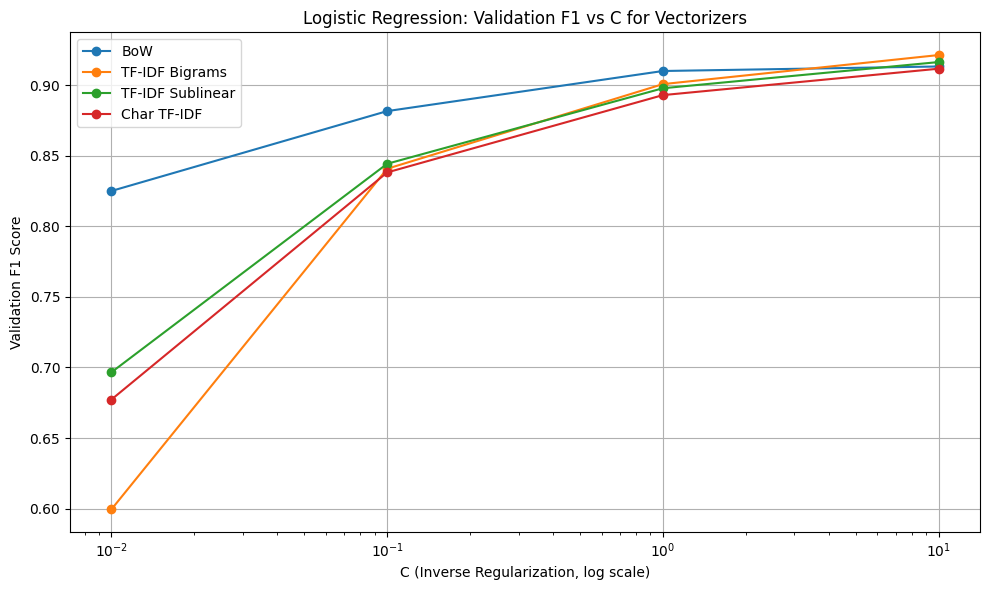

In [21]:
import os
import matplotlib.pyplot as plt

# 📁 Ensure output directory exists
os.makedirs("models/plots", exist_ok=True)

plt.figure(figsize=(10, 6))
for name, (_, f1s) in results.items():
    plt.plot(C_values, f1s, marker='o', label=name)

plt.xscale("log")
plt.xlabel("C (Inverse Regularization, log scale)")
plt.ylabel("Validation F1 Score")
plt.title("Logistic Regression: Validation F1 vs C for Vectorizers")
plt.legend()
plt.grid(True)
plt.tight_layout()

# 💾 Save the plot
plot_path = "models/plots/logreg_val_f1_vs_c_all_vectorizers.png"
plt.savefig(plot_path, dpi=300)
print(f"✅ Plot saved to: {plot_path}")

# 👁️ Show the plot
plt.show()

In [22]:
import os
from sklearn.metrics import classification_report, roc_auc_score, f1_score
import pandas as pd

# 📁 Ensure save directories exist
os.makedirs("models/results", exist_ok=True)

final_scores = []
csv_rows = []

for name, (vectorizer, f1s) in results.items():
    best_C = C_values[f1s.index(max(f1s))]

    # Train on train+val
    X_train_vec = vectorizer.fit_transform(pd.concat([X_train, X_val]))
    X_test_vec = vectorizer.transform(X_test)
    y_trainval = pd.concat([y_train, y_val])

    clf = LogisticRegression(C=best_C, penalty="l2", solver="liblinear", max_iter=1000)
    clf.fit(X_train_vec, y_trainval)

    # Evaluate
    y_test_pred = clf.predict(X_test_vec)
    y_test_prob = clf.predict_proba(X_test_vec)[:, 1]
    auc = roc_auc_score(y_test, y_test_prob)
    f1 = f1_score(y_test, y_test_pred)

    # 🖨️ Print report
    print(f"\n🧪 Vectorizer: {name} | Best C = {best_C}")
    report_text = classification_report(y_test, y_test_pred, target_names=["Real", "Fake"])
    print(report_text)
    print(f"ROC AUC: {auc:.4f}")

    # 💾 Save full classification report
    with open(f"models/results/classification_report_{name.replace(' ', '_')}.txt", "w") as f:
        f.write(f"Vectorizer: {name} | Best C = {best_C}\n\n")
        f.write(report_text + "\n")
        f.write(f"ROC AUC: {auc:.4f}\n")

    # Append for summary CSV
    final_scores.append((name, best_C, f1, auc, clf, vectorizer))
    csv_rows.append({
        "Vectorizer": name,
        "Best C": best_C,
        "F1 Score": f1,
        "ROC AUC": auc
    })

# 💾 Save summary CSV
df_summary = pd.DataFrame(csv_rows)
df_summary.to_csv("models/results/logreg_test_scores.csv", index=False)
print("✅ Summary saved to models/results/logreg_test_scores.csv")


🧪 Vectorizer: BoW | Best C = 10
              precision    recall  f1-score   support

        Real       0.92      0.94      0.93      3000
        Fake       0.92      0.90      0.91      2395

    accuracy                           0.92      5395
   macro avg       0.92      0.92      0.92      5395
weighted avg       0.92      0.92      0.92      5395

ROC AUC: 0.9716

🧪 Vectorizer: TF-IDF Bigrams | Best C = 10
              precision    recall  f1-score   support

        Real       0.93      0.94      0.93      3000
        Fake       0.92      0.91      0.92      2395

    accuracy                           0.93      5395
   macro avg       0.93      0.92      0.92      5395
weighted avg       0.93      0.93      0.93      5395

ROC AUC: 0.9771

🧪 Vectorizer: TF-IDF Sublinear | Best C = 10
              precision    recall  f1-score   support

        Real       0.92      0.95      0.93      3000
        Fake       0.93      0.89      0.91      2395

    accuracy               

In [23]:
# 📊 Sort all models by Test F1 Score (descending)
sorted_final = sorted(final_scores, key=lambda x: x[2], reverse=True)  # x[2] = F1

# 📋 Print sorted table
print("\n📊 Sorted Models by Test F1 Score:")
print(f"{'Rank':<4} {'Vectorizer':<20} {'Best C':<6} {'F1 Score':<8} {'ROC AUC':<8}")
print("-" * 50)

for i, (name, best_C, f1, auc, _, _) in enumerate(sorted_final, 1):
    print(f"{i:<4} {name:<20} {best_C:<6} {f1:<8.4f} {auc:<8.4f}")

# 🏆 Pick the best model (top entry after sort)
best_name, best_C, best_f1, best_auc, best_model, best_vectorizer = sorted_final[0]

print(f"\n🏆 Best Model: {best_name} | C={best_C} | F1={best_f1:.4f} | AUC={best_auc:.4f}")


📊 Sorted Models by Test F1 Score:
Rank Vectorizer           Best C F1 Score ROC AUC 
--------------------------------------------------
1    TF-IDF Bigrams       10     0.9158   0.9771  
2    TF-IDF Sublinear     10     0.9134   0.9744  
3    Char TF-IDF          10     0.9092   0.9745  
4    BoW                  10     0.9082   0.9716  

🏆 Best Model: TF-IDF Bigrams | C=10 | F1=0.9158 | AUC=0.9771


In [24]:
# 💾 Save sorted results
sorted_results_df = pd.DataFrame([{
    "Rank": i,
    "Vectorizer": name,
    "Best C": best_C,
    "F1 Score": f1,
    "ROC AUC": auc
} for i, (name, best_C, f1, auc, _, _) in enumerate(sorted_final, 1)])

sorted_results_df.to_csv("models/results/sorted_logreg_test_scores.csv", index=False)
print("✅ Sorted model scores saved to models/results/sorted_logreg_test_scores.csv")

✅ Sorted model scores saved to models/results/sorted_logreg_test_scores.csv


In [25]:
import os
import shap
import lime
import lime.lime_text
from IPython.display import display, HTML
import matplotlib.pyplot as plt

# 📁 Ensure output directory exists
os.makedirs("models/plots/lime", exist_ok=True)
os.makedirs("models/plots/shap", exist_ok=True)

print("🔄 Running LIME + SHAP explanations for all models...\n")

# Recombine train set once
X_trainval = pd.concat([X_train, X_val])

for name, best_C, _, _, model, vectorizer in final_scores:
    print(f"\n🔍 Vectorizer: {name} | C = {best_C}")

    # -------------------
    # 🧠 LIME Explanation
    # -------------------
    try:
        lime_explainer = lime.lime_text.LimeTextExplainer(class_names=["Real", "Fake"])

        def predict_proba(texts):
            vec = vectorizer.transform(texts)
            return model.predict_proba(vec)

        idx = 10
        headline = X_test.iloc[idx]
        print(f"🧠 LIME → Explaining: \"{headline}\"")

        lime_exp = lime_explainer.explain_instance(headline, predict_proba, num_features=10)

        lime_file = f"models/plots/lime/lime_{name.replace(' ', '_')}.html"
        lime_exp.save_to_file(lime_file)
        print(f"✅ LIME saved to {lime_file}")
    except Exception as e:
        print(f"❌ LIME failed for {name}: {e}")

    # -------------------
    # 🔬 SHAP Explanation
    # -------------------
    try:
        X_trainval_vec = vectorizer.transform(X_trainval)
        X_test_vec = vectorizer.transform(X_test[:50])  # small subset

        shap_explainer = shap.Explainer(model, X_trainval_vec, feature_names=vectorizer.get_feature_names_out())
        shap_values = shap_explainer(X_test_vec)

        plt.title(f"SHAP Feature Importance – {name}")
        shap.plots.bar(shap_values.mean(0), max_display=15, show=False)
        plt.tight_layout()

        shap_path = f"models/plots/shap/shap_{name.replace(' ', '_')}.png"
        plt.savefig(shap_path, dpi=300)
        plt.close()
        print(f"✅ SHAP saved to {shap_path}")
    except Exception as e:
        print(f"❌ SHAP failed for {name}: {e}")

🔄 Running LIME + SHAP explanations for all models...


🔍 Vectorizer: BoW | C = 10
🧠 LIME → Explaining: "catch cctv suv driver run security guard honk dispute"
✅ LIME saved to models/plots/lime/lime_BoW.html
✅ SHAP saved to models/plots/shap/shap_BoW.png

🔍 Vectorizer: TF-IDF Bigrams | C = 10
🧠 LIME → Explaining: "catch cctv suv driver run security guard honk dispute"
✅ LIME saved to models/plots/lime/lime_TF-IDF_Bigrams.html
✅ SHAP saved to models/plots/shap/shap_TF-IDF_Bigrams.png

🔍 Vectorizer: TF-IDF Sublinear | C = 10
🧠 LIME → Explaining: "catch cctv suv driver run security guard honk dispute"
✅ LIME saved to models/plots/lime/lime_TF-IDF_Sublinear.html
✅ SHAP saved to models/plots/shap/shap_TF-IDF_Sublinear.png

🔍 Vectorizer: Char TF-IDF | C = 10
🧠 LIME → Explaining: "catch cctv suv driver run security guard honk dispute"
✅ LIME saved to models/plots/lime/lime_Char_TF-IDF.html
✅ SHAP saved to models/plots/shap/shap_Char_TF-IDF.png



🧠 Vectorizer: TF-IDF Bigrams
🔍 LIME Explanation:


📊 SHAP Global Feature Importance:


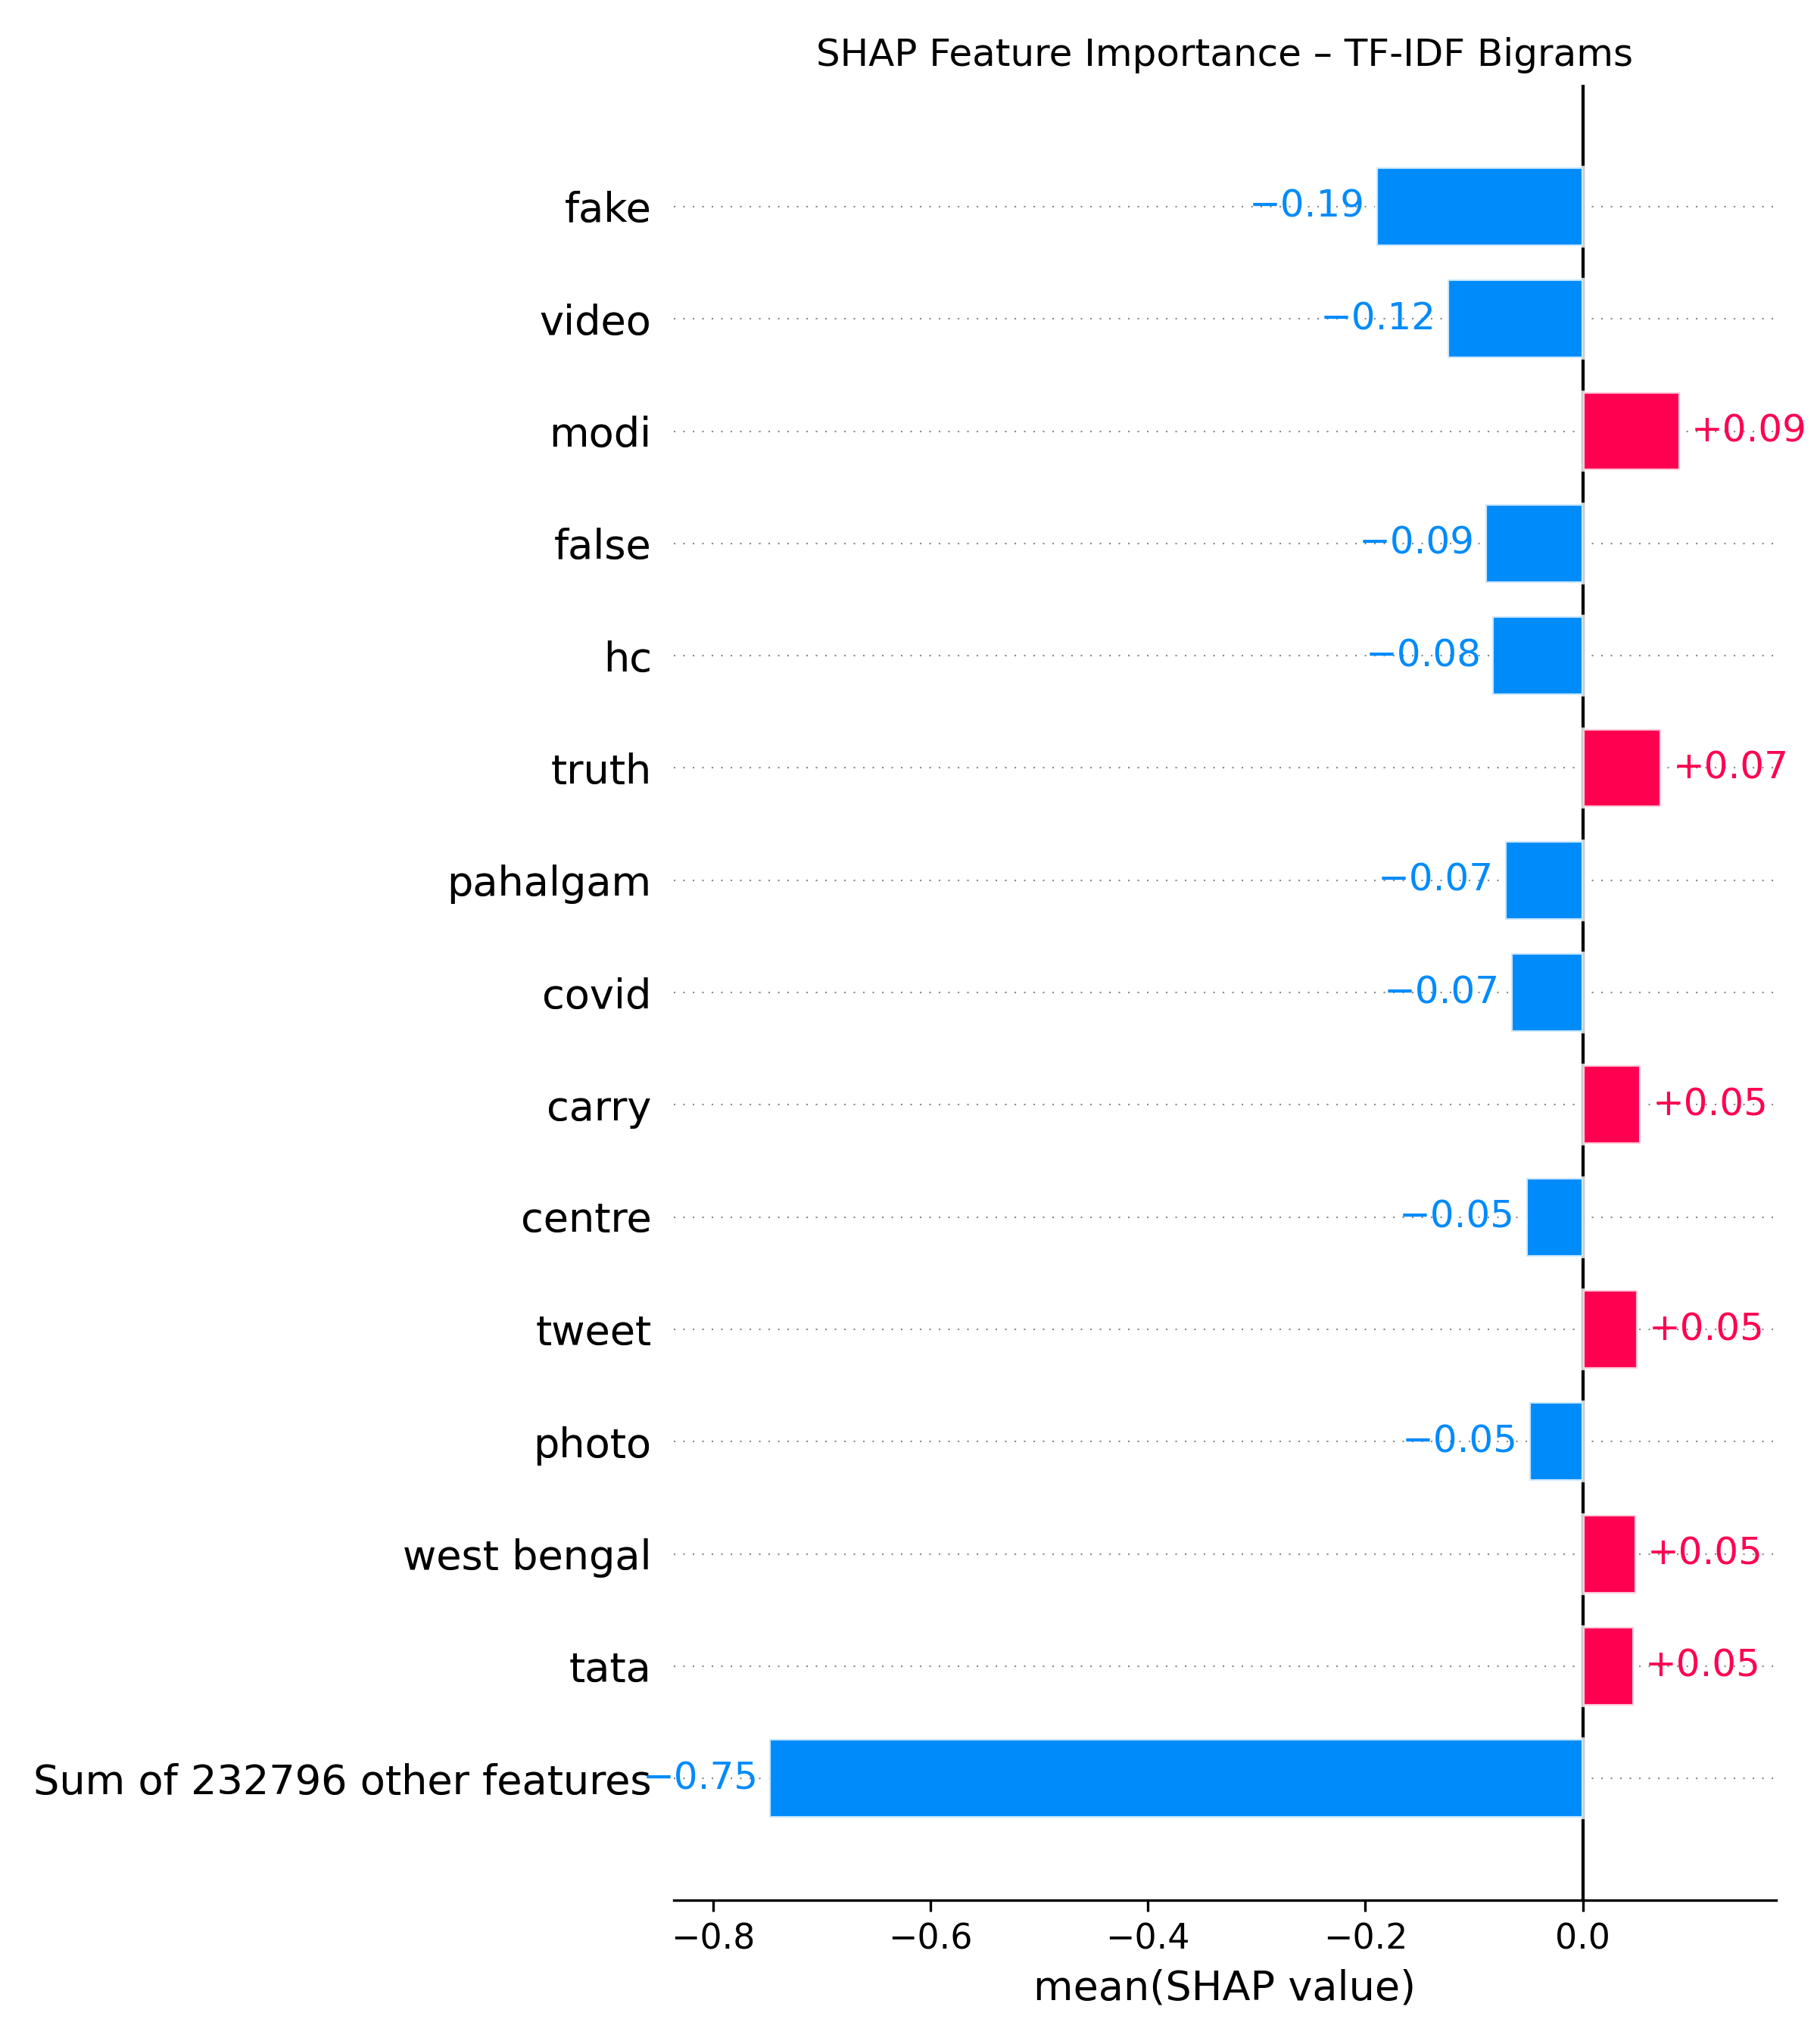


🧠 Vectorizer: TF-IDF Sublinear
🔍 LIME Explanation:


📊 SHAP Global Feature Importance:


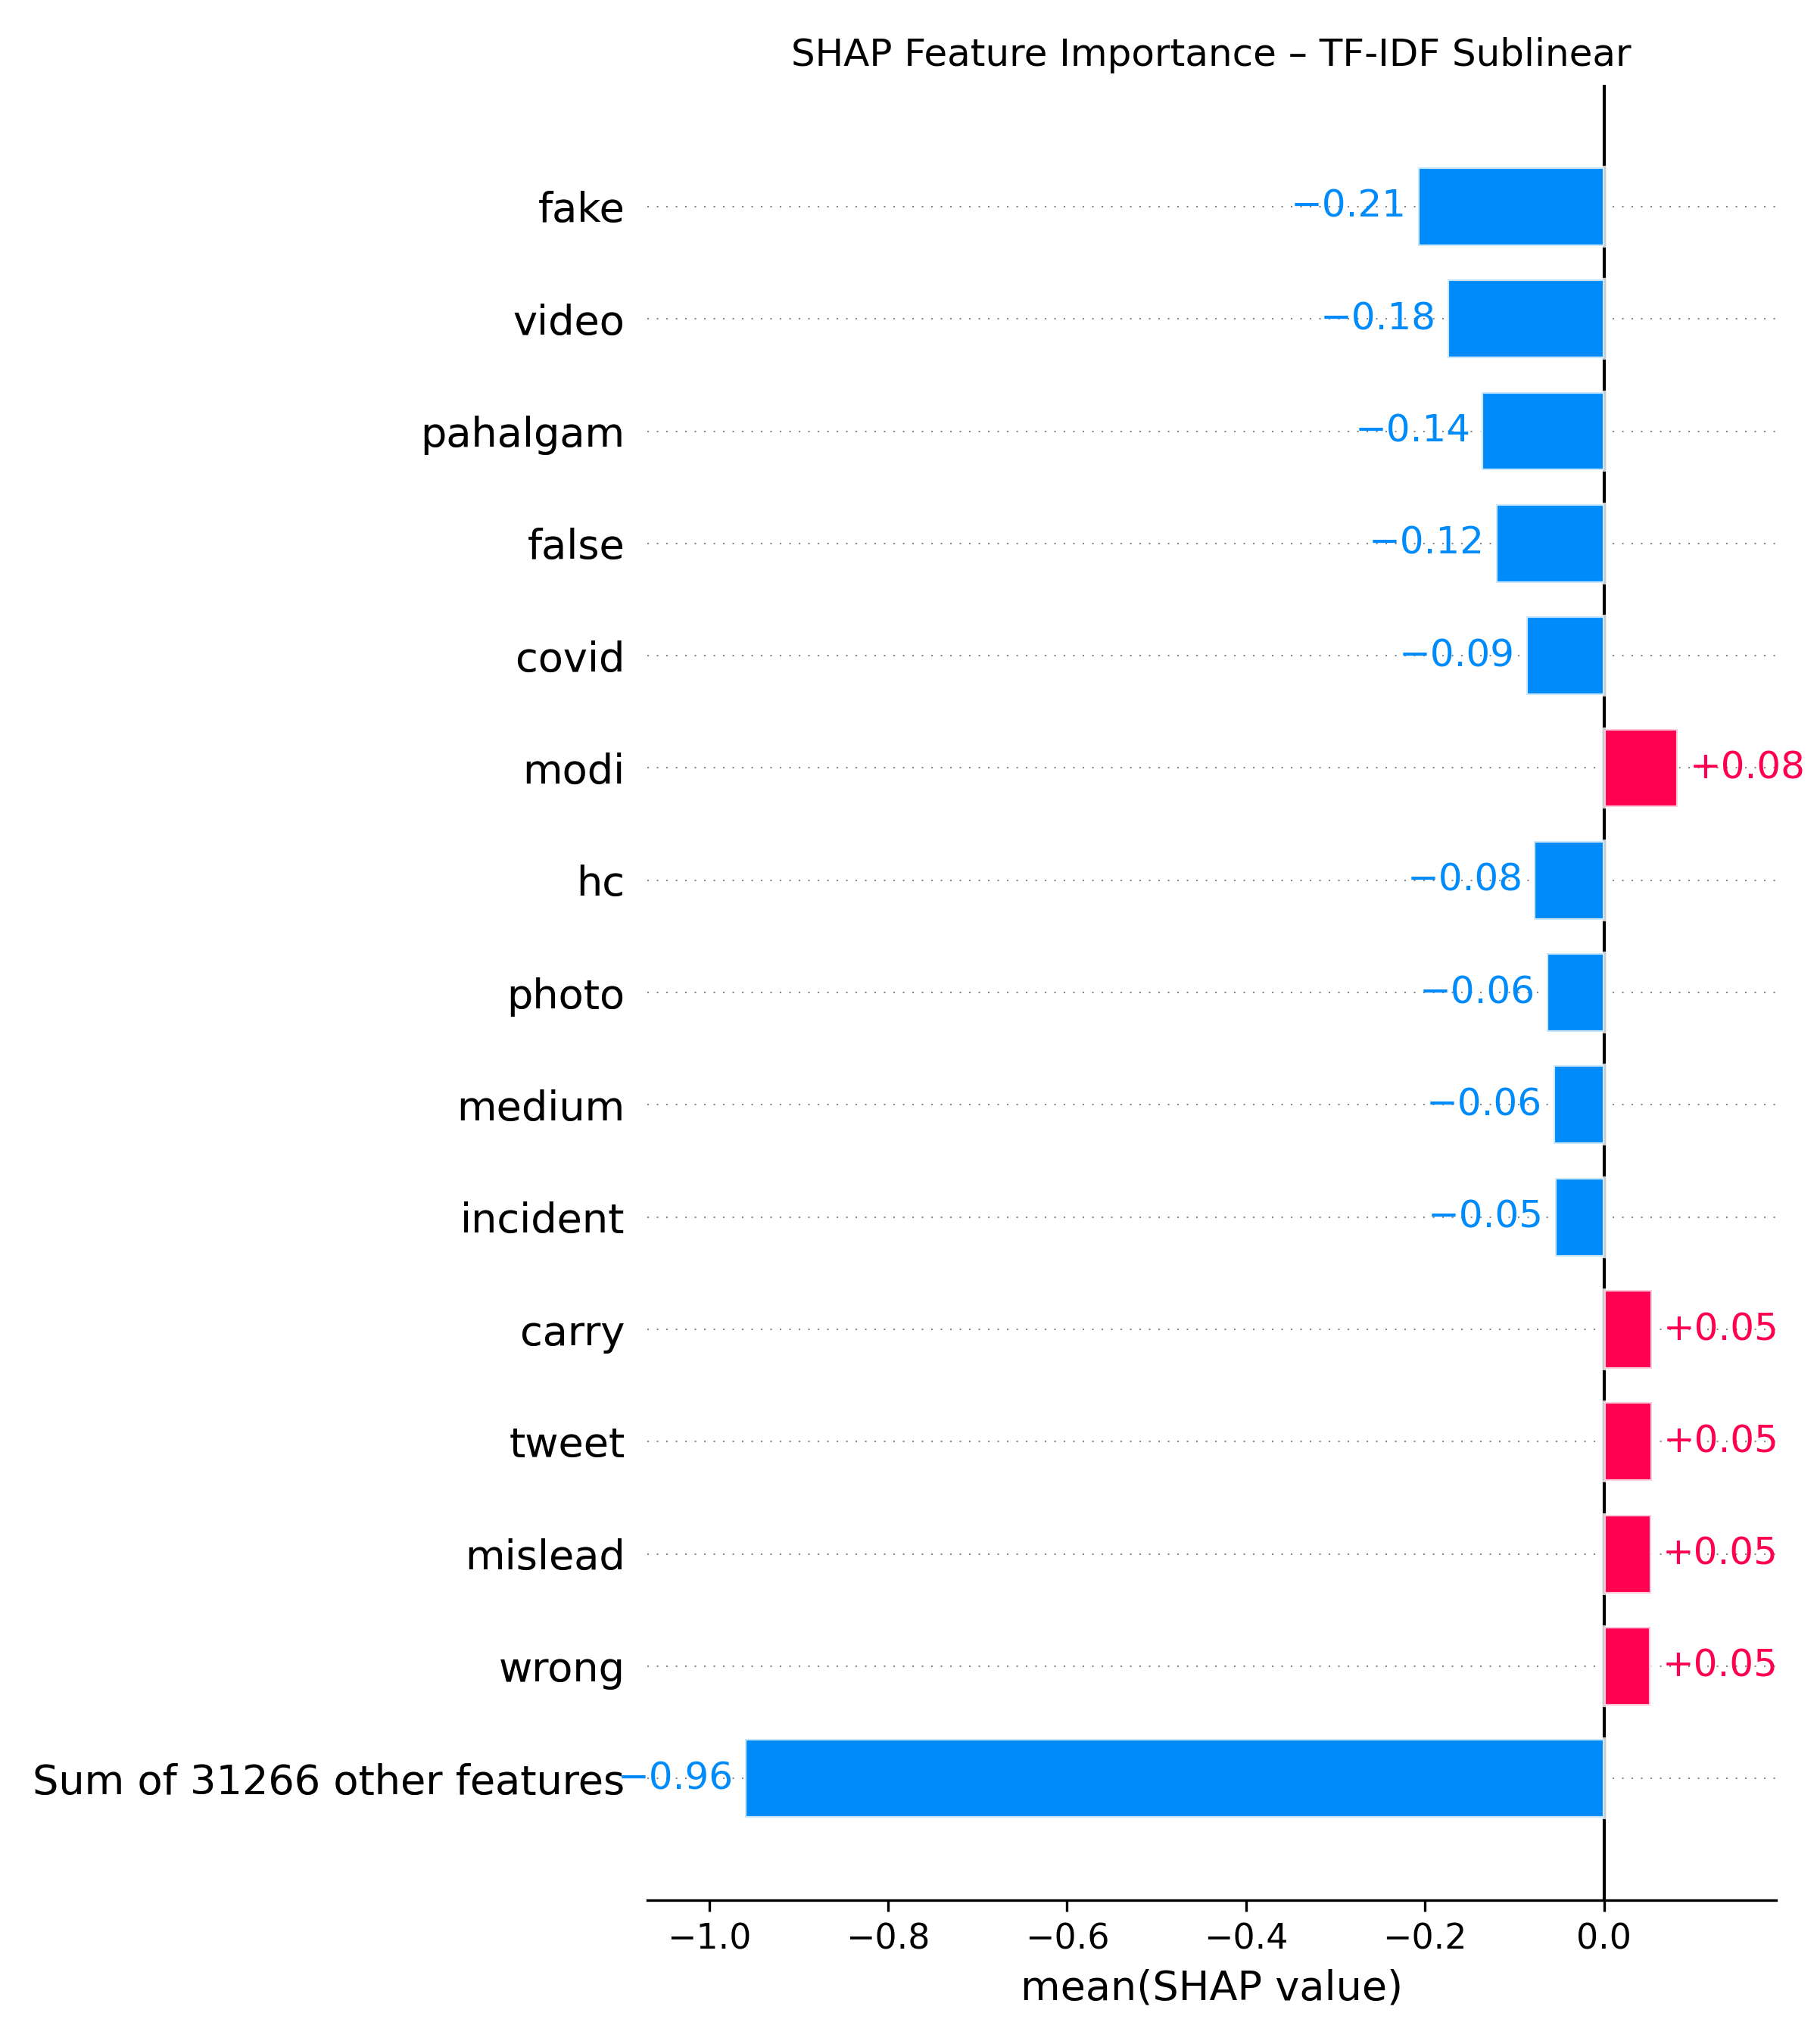


🧠 Vectorizer: Char TF-IDF
🔍 LIME Explanation:


📊 SHAP Global Feature Importance:


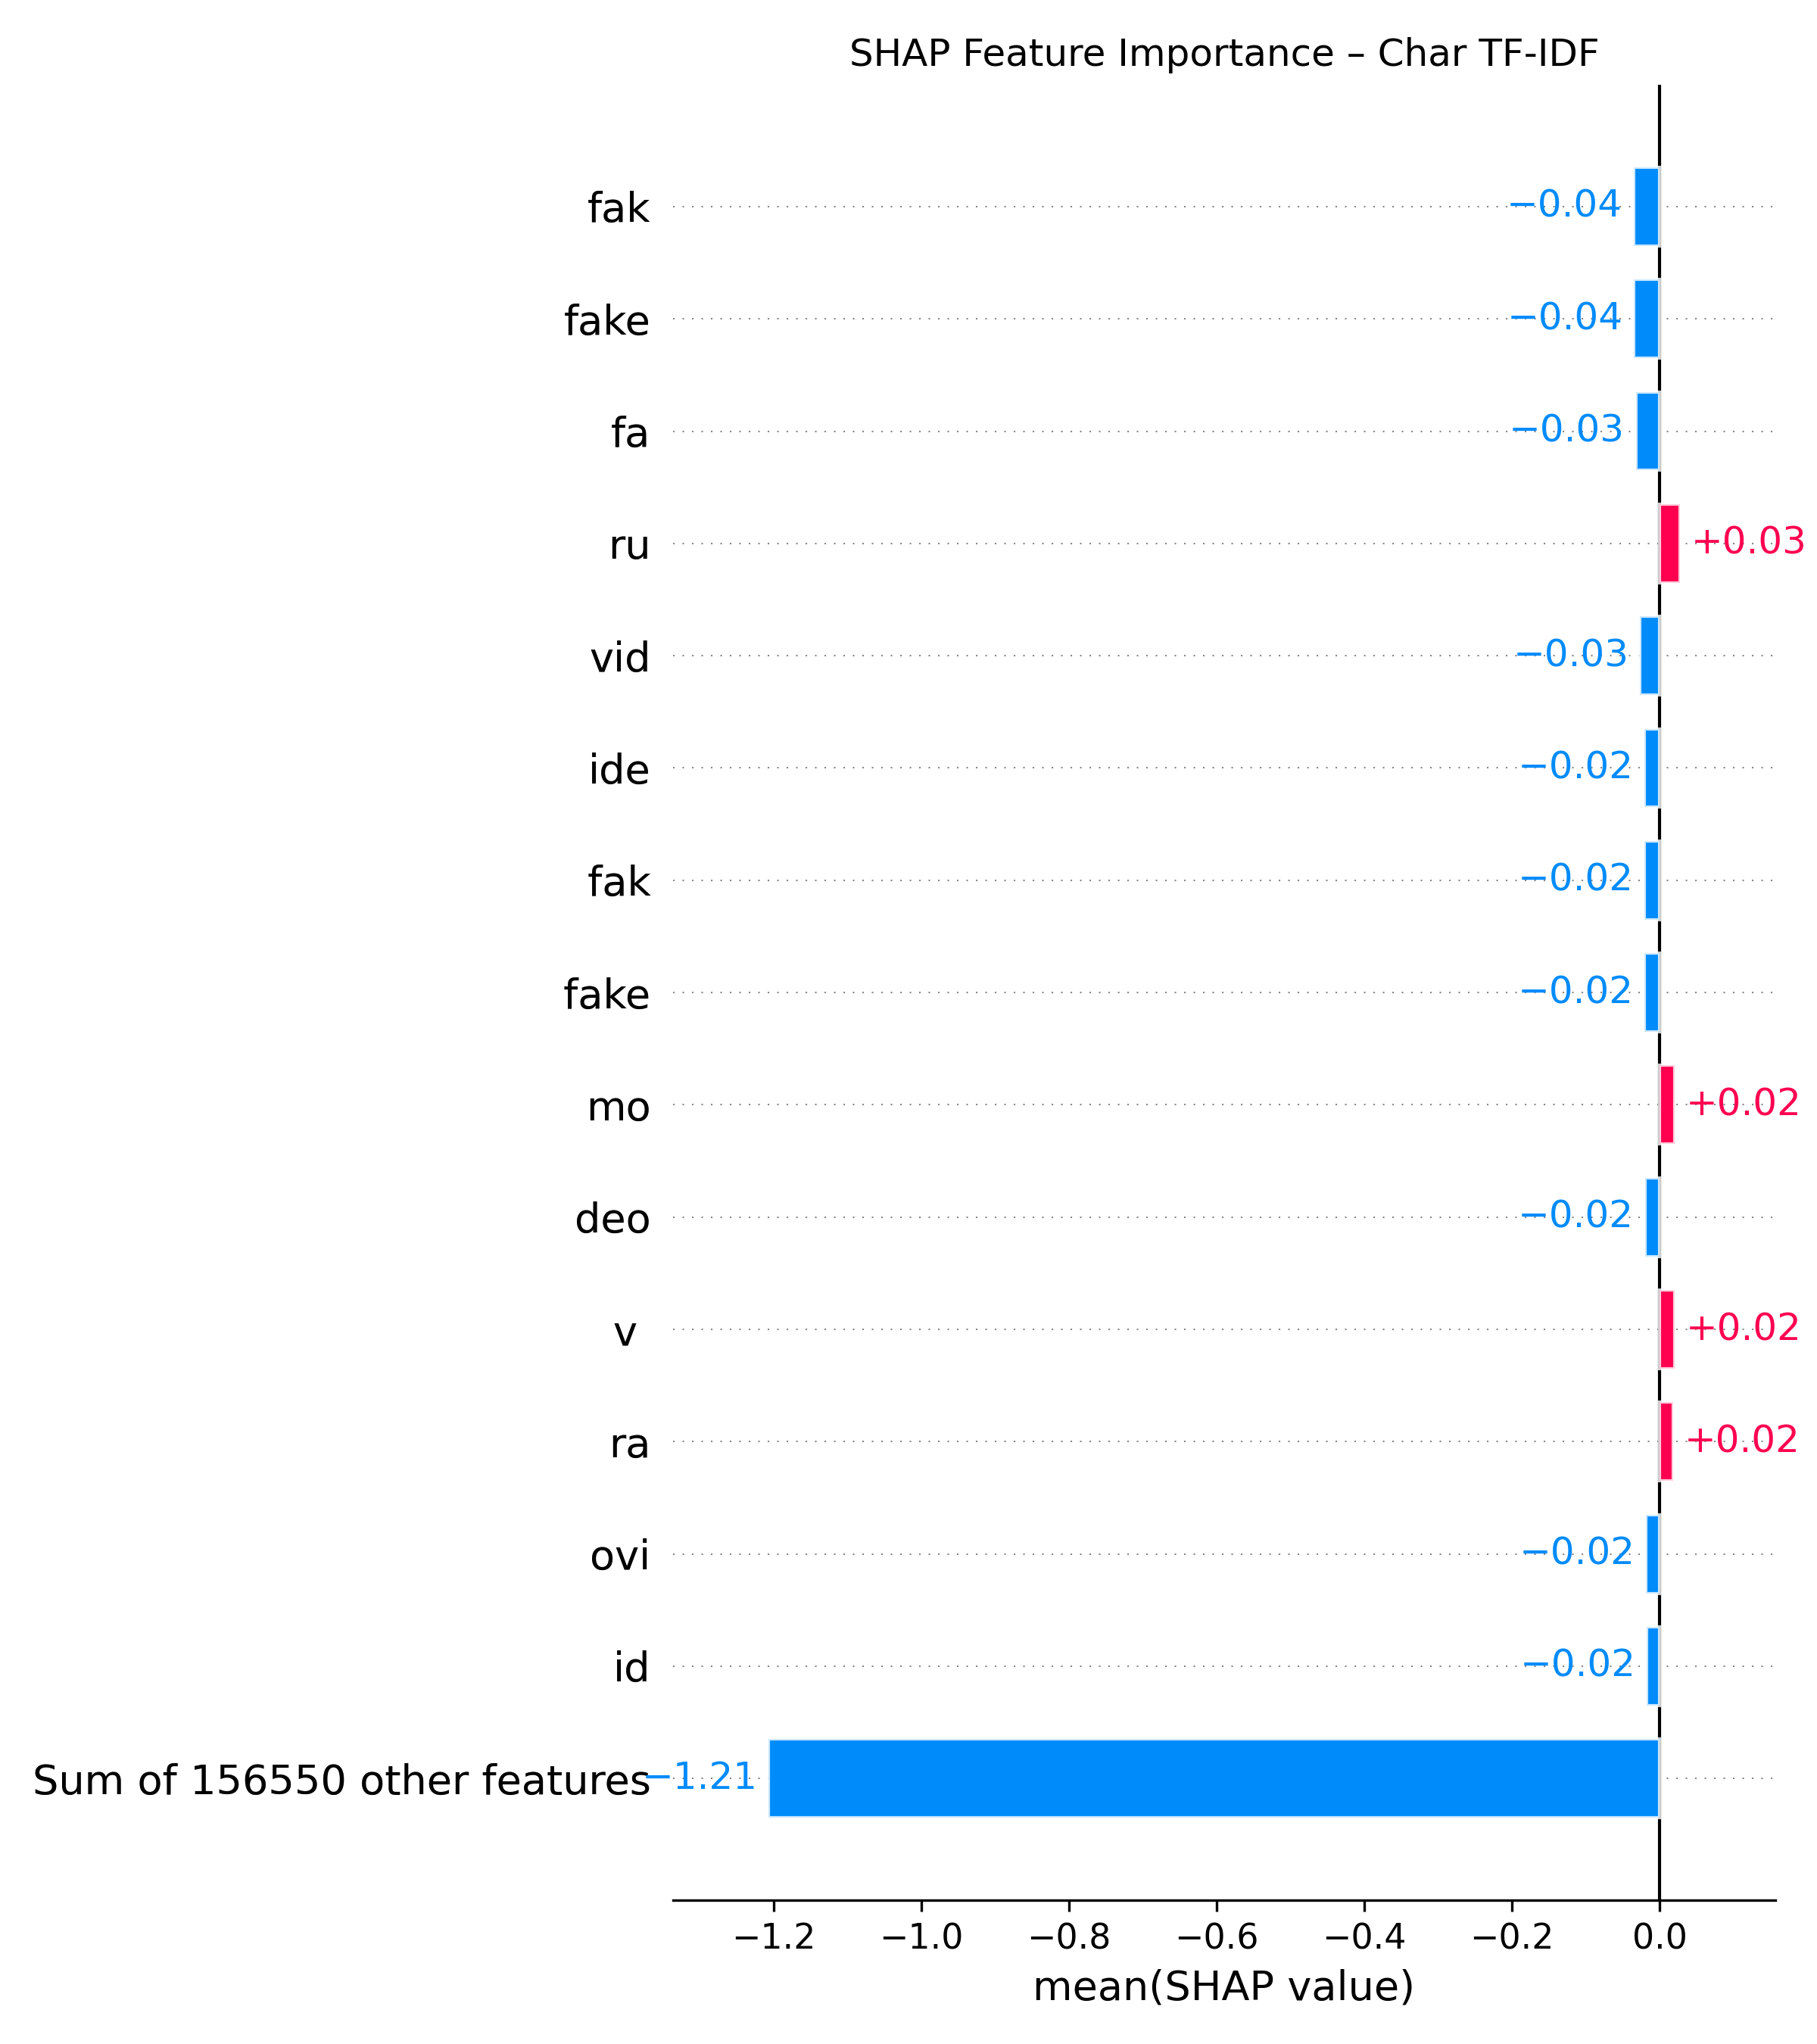


🧠 Vectorizer: BoW
🔍 LIME Explanation:


📊 SHAP Global Feature Importance:


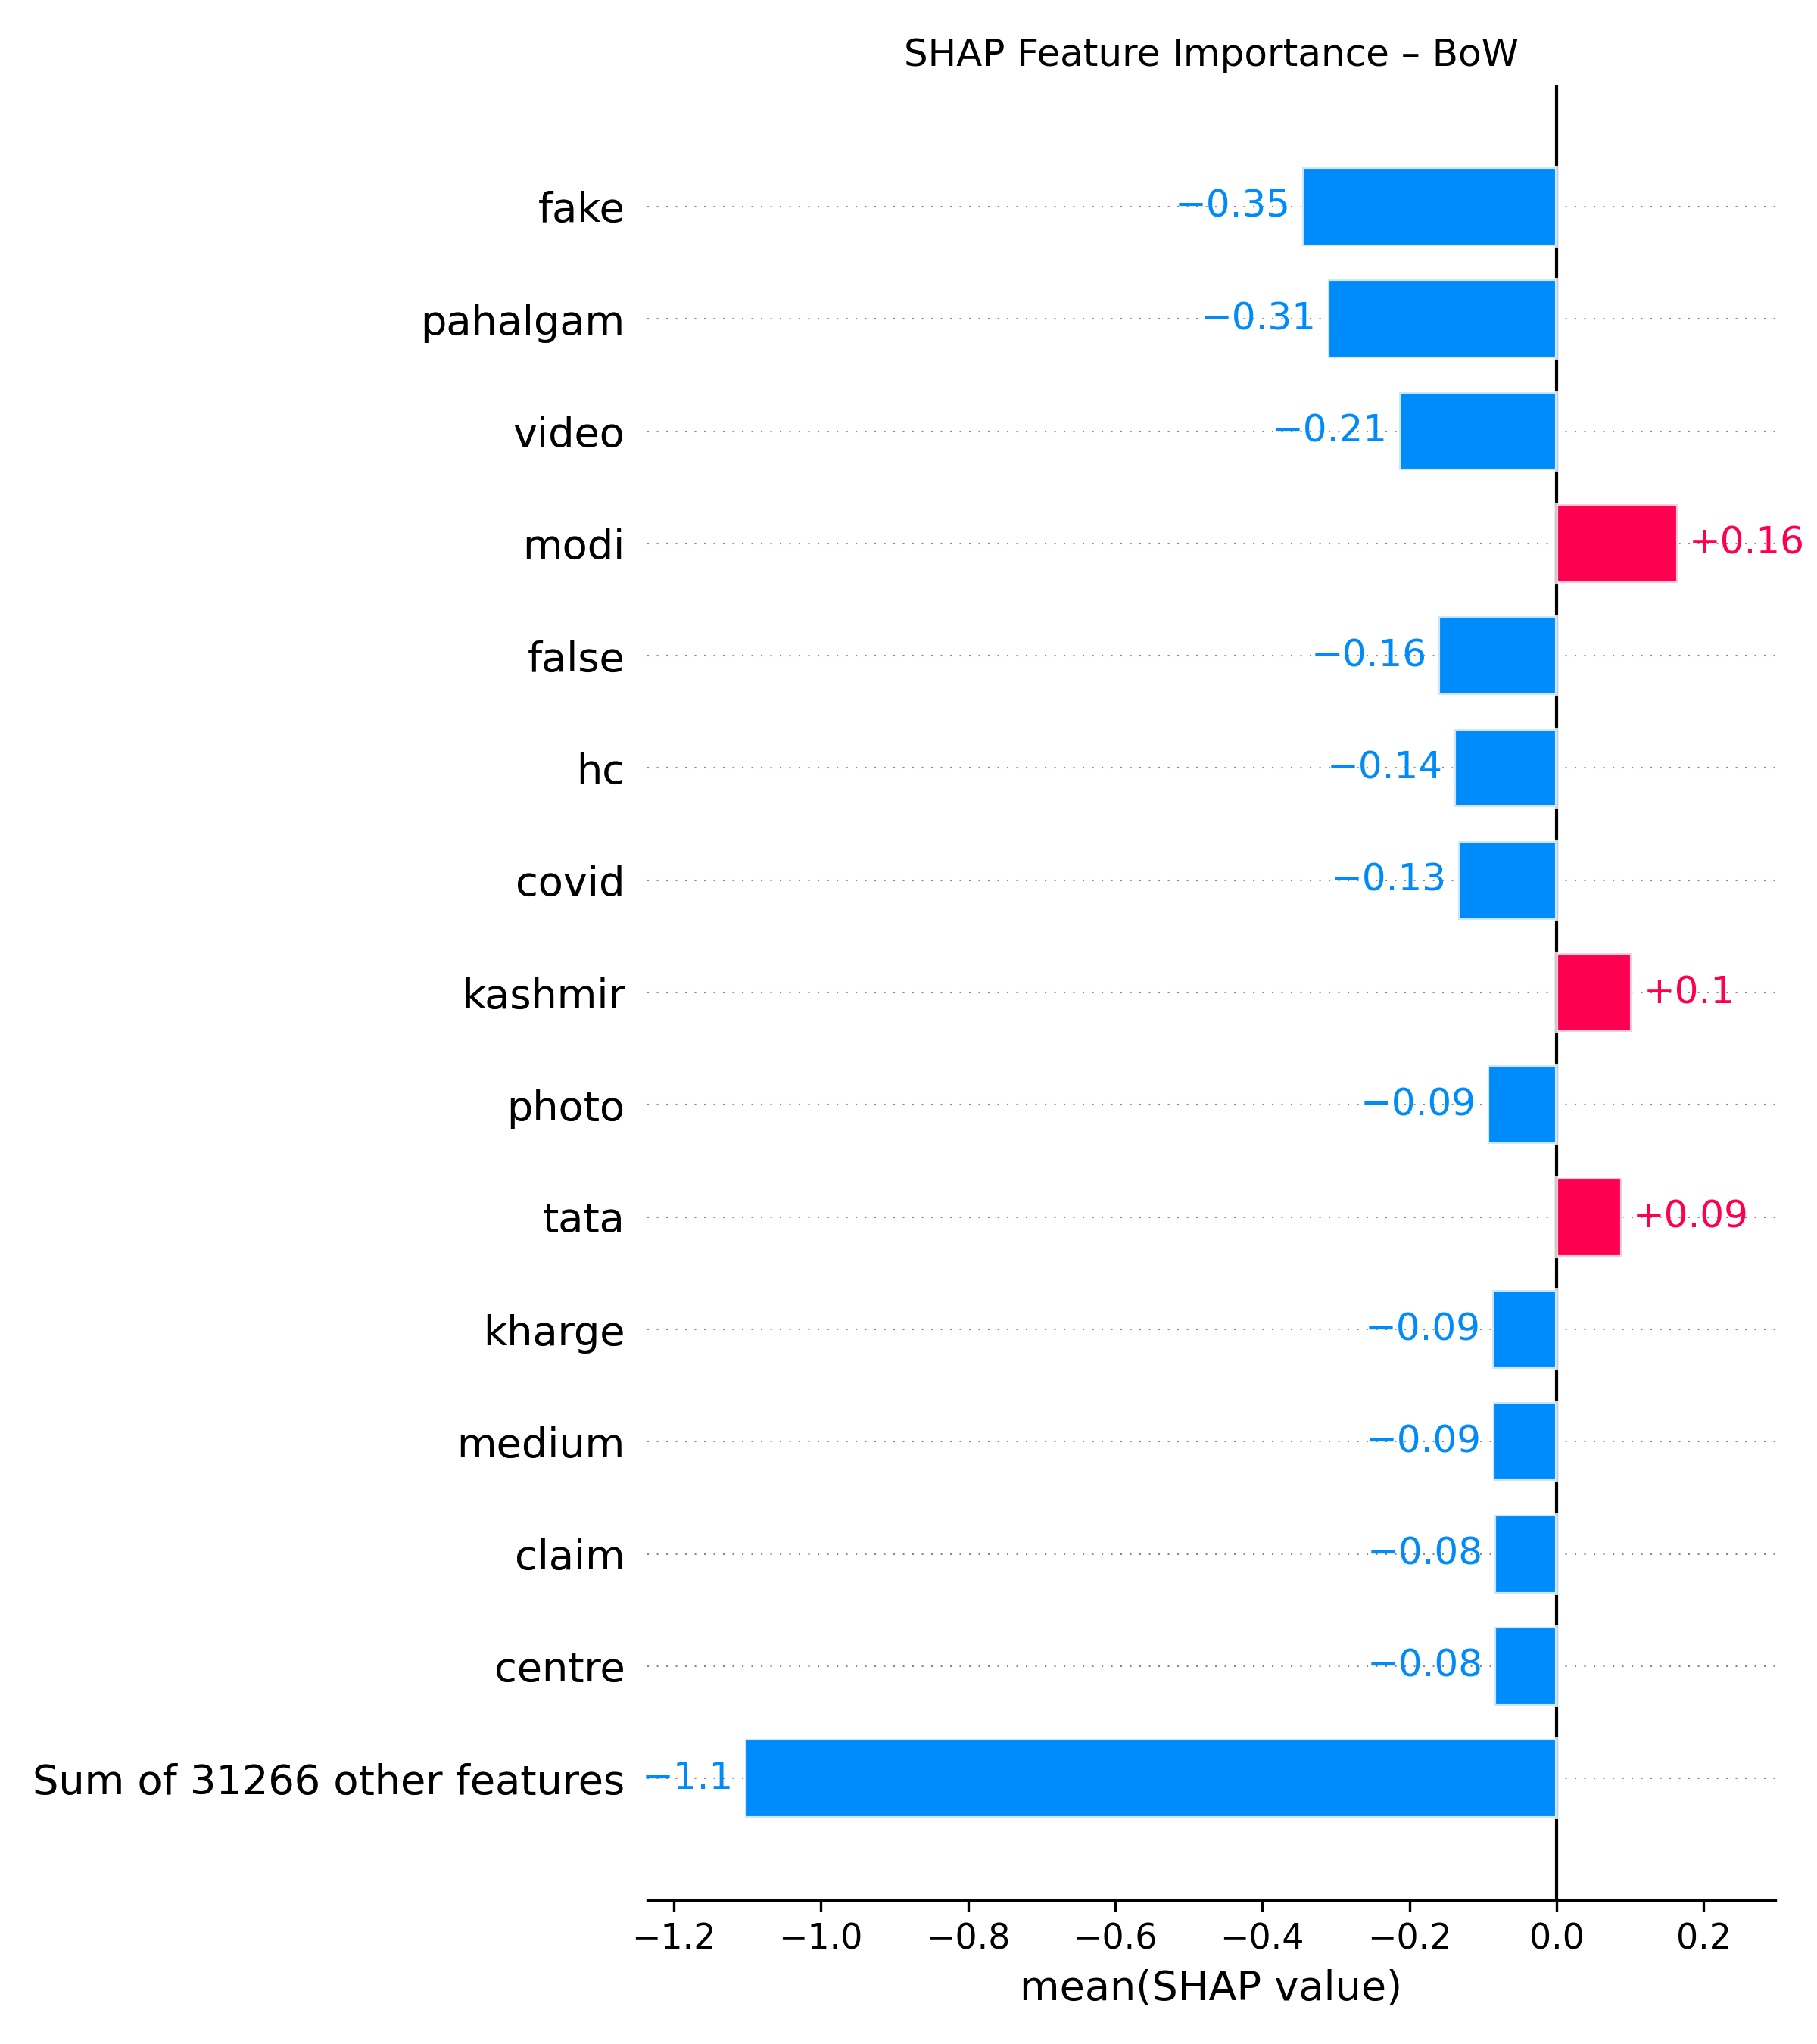

In [26]:
from IPython.display import display, HTML, Image
import os

# 📁 Paths
lime_dir = "models/plots/lime"
shap_dir = "models/plots/shap"

# 🔁 Loop through all vectorizers in sorted order
for name, _, _, _, _, _ in sorted_final:
    clean_name = name.replace(" ", "_")
    
    print(f"\n🧠 Vectorizer: {name}")

    # 🔹 LIME Display
    lime_file = os.path.join(lime_dir, f"lime_{clean_name}.html")
    if os.path.exists(lime_file):
        print("🔍 LIME Explanation:")
        display(HTML(filename=lime_file))
    else:
        print("⚠️ LIME HTML not found.")

    # 🔹 SHAP Display
    shap_file = os.path.join(shap_dir, f"shap_{clean_name}.png")
    if os.path.exists(shap_file):
        print("📊 SHAP Global Feature Importance:")
        display(Image(filename=shap_file))
    else:
        print("⚠️ SHAP plot not found.")

In [4]:
import os
import time
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings("ignore")

# 📁 Ensure output dir
os.makedirs("models/results/penalty_solver_grid", exist_ok=True)

# 📄 Load cleaned data
train_df = pd.read_csv("data/processed_train.csv").dropna(subset=["clean_headline"])
val_df = pd.read_csv("data/processed_val.csv").dropna(subset=["clean_headline"])
X_train = train_df["clean_headline"].astype(str).reset_index(drop=True)
y_train = train_df["label_encoded"].reset_index(drop=True)
X_val = val_df["clean_headline"].astype(str).reset_index(drop=True)
y_val = val_df["label_encoded"].reset_index(drop=True)

# 🧠 TF-IDF Bigrams
vectorizer_name = "TF-IDF Bigrams"
vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=2)
X_train_vec = vectorizer.fit_transform(X_train)
X_val_vec = vectorizer.transform(X_val)

print(f"✅ Vectorized shape: {X_train_vec.shape}, Memory: {X_train_vec.data.nbytes / (1024*1024):.2f} MB")

# 🔧 Minimal Grid (Safe)
C_values = [0.01, 0.1, 1, 10, 100]
solvers = ["liblinear", "saga", "lbfgs"]
penalty = "l2"

results = []

# 🔄 Loop
for solver in solvers:
    for C in C_values:
        try:
            print(f"\n🔧 Testing config: {{'solver': '{solver}', 'penalty': '{penalty}', 'C': {C}}}")
            start = time.time()
            clf = LogisticRegression(C=C, solver=solver, penalty=penalty, max_iter=2000)
            clf.fit(X_train_vec, y_train)
            f1 = f1_score(y_val, clf.predict(X_val_vec))
            elapsed = time.time() - start
            print(f"✅ F1 Score: {f1:.4f} | Time: {elapsed:.2f}s")
            results.append((vectorizer_name, solver, penalty, C, f1))
        except Exception as e:
            print(f"❌ Error: {e}")
            continue

# 💾 Save
df_results = pd.DataFrame(results, columns=["Vectorizer", "Solver", "Penalty", "C", "Val_F1"])
csv_path = "models/results/penalty_solver_grid/grid_results_TFIDF_Bigrams_SAFE.csv"
df_results.to_csv(csv_path, index=False)
print(f"\n📁 Results saved to: {csv_path}")

✅ Vectorized shape: (43157, 42003), Memory: 3.01 MB

🔧 Testing config: {'solver': 'liblinear', 'penalty': 'l2', 'C': 0.01}
✅ F1 Score: 0.6472 | Time: 0.03s

🔧 Testing config: {'solver': 'liblinear', 'penalty': 'l2', 'C': 0.1}
✅ F1 Score: 0.8430 | Time: 0.08s

🔧 Testing config: {'solver': 'liblinear', 'penalty': 'l2', 'C': 1}
✅ F1 Score: 0.9007 | Time: 0.16s

🔧 Testing config: {'solver': 'liblinear', 'penalty': 'l2', 'C': 10}
✅ F1 Score: 0.9215 | Time: 0.29s

🔧 Testing config: {'solver': 'liblinear', 'penalty': 'l2', 'C': 100}
✅ F1 Score: 0.9168 | Time: 0.34s

🔧 Testing config: {'solver': 'saga', 'penalty': 'l2', 'C': 0.01}
✅ F1 Score: 0.6449 | Time: 0.19s

🔧 Testing config: {'solver': 'saga', 'penalty': 'l2', 'C': 0.1}
✅ F1 Score: 0.8430 | Time: 0.14s

🔧 Testing config: {'solver': 'saga', 'penalty': 'l2', 'C': 1}
✅ F1 Score: 0.9007 | Time: 0.13s

🔧 Testing config: {'solver': 'saga', 'penalty': 'l2', 'C': 10}
✅ F1 Score: 0.9215 | Time: 0.29s

🔧 Testing config: {'solver': 'saga', 'penalt

In [1]:
import os
import time
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
import warnings

warnings.filterwarnings("ignore")

# 📁 Ensure directory exists
os.makedirs("models/results/penalty_solver_grid", exist_ok=True)

# 📄 Load data
train_df = pd.read_csv("data/processed_train.csv").dropna(subset=["clean_headline"])
val_df = pd.read_csv("data/processed_val.csv").dropna(subset=["clean_headline"])

X_train = train_df["clean_headline"].astype(str).reset_index(drop=True)
y_train = train_df["label_encoded"].reset_index(drop=True)
X_val = val_df["clean_headline"].astype(str).reset_index(drop=True)
y_val = val_df["label_encoded"].reset_index(drop=True)

# 🔠 Vectorizer: Char TF-IDF
vectorizer_name = "Char TF-IDF"
vectorizer = TfidfVectorizer(analyzer="char", ngram_range=(2, 5), min_df=2)
X_train_vec = vectorizer.fit_transform(X_train)
X_val_vec = vectorizer.transform(X_val)

print(f"✅ Vectorized shape: {X_train_vec.shape}, Memory: {X_train_vec.data.nbytes / (1024 * 1024):.2f} MB")

# 🔧 Grid configs
C_values = [0.01, 0.1, 1, 10, 100]
solvers = ["liblinear", "saga", "lbfgs"]
penalty = "l2"  # Only L2 for speed and stability

results = []
print(f"\n🚀 Running grid search for {vectorizer_name}...")

for solver in tqdm(solvers, desc="🔄 Grid Search"):
    for C in C_values:
        try:
            print(f"\n🔧 Testing config: solver={solver}, penalty={penalty}, C={C}")
            start = time.time()
            clf = LogisticRegression(C=C, solver=solver, penalty=penalty, max_iter=2000)
            clf.fit(X_train_vec, y_train)
            f1 = f1_score(y_val, clf.predict(X_val_vec))
            elapsed = time.time() - start
            print(f"✅ F1 Score: {f1:.4f} | Time: {elapsed:.2f}s")
            results.append((vectorizer_name, solver, penalty, C, None, f1))
        except Exception as e:
            print(f"⚠️ Skipped: {e}")

# 💾 Save results
df_results = pd.DataFrame(results, columns=["Vectorizer", "Solver", "Penalty", "C", "L1_ratio", "Val_F1"])
df_results.to_csv("models/results/penalty_solver_grid/grid_results_Char_TFIDF.csv", index=False)
print("📁 Results saved to: grid_results_Char_TFIDF.csv")

✅ Vectorized shape: (43157, 149193), Memory: 55.12 MB

🚀 Running grid search for Char TF-IDF...


🔄 Grid Search:   0%|                                          | 0/3 [00:00<?, ?it/s]


🔧 Testing config: solver=liblinear, penalty=l2, C=0.01
✅ F1 Score: 0.6773 | Time: 0.44s

🔧 Testing config: solver=liblinear, penalty=l2, C=0.1
✅ F1 Score: 0.8383 | Time: 0.65s

🔧 Testing config: solver=liblinear, penalty=l2, C=1
✅ F1 Score: 0.8931 | Time: 1.06s

🔧 Testing config: solver=liblinear, penalty=l2, C=10
✅ F1 Score: 0.9118 | Time: 1.98s

🔧 Testing config: solver=liblinear, penalty=l2, C=100


🔄 Grid Search:  33%|███████████▎                      | 1/3 [00:06<00:12,  6.41s/it]

✅ F1 Score: 0.9114 | Time: 2.28s

🔧 Testing config: solver=saga, penalty=l2, C=0.01
✅ F1 Score: 0.6747 | Time: 1.07s

🔧 Testing config: solver=saga, penalty=l2, C=0.1
✅ F1 Score: 0.8380 | Time: 1.09s

🔧 Testing config: solver=saga, penalty=l2, C=1
✅ F1 Score: 0.8928 | Time: 1.13s

🔧 Testing config: solver=saga, penalty=l2, C=10
✅ F1 Score: 0.9120 | Time: 2.74s

🔧 Testing config: solver=saga, penalty=l2, C=100


🔄 Grid Search:  67%|██████████████████████▋           | 2/3 [00:22<00:12, 12.33s/it]

✅ F1 Score: 0.9121 | Time: 10.45s

🔧 Testing config: solver=lbfgs, penalty=l2, C=0.01
✅ F1 Score: 0.6744 | Time: 0.40s

🔧 Testing config: solver=lbfgs, penalty=l2, C=0.1
✅ F1 Score: 0.8384 | Time: 0.71s

🔧 Testing config: solver=lbfgs, penalty=l2, C=1
✅ F1 Score: 0.8933 | Time: 1.24s

🔧 Testing config: solver=lbfgs, penalty=l2, C=10
✅ F1 Score: 0.9128 | Time: 1.77s

🔧 Testing config: solver=lbfgs, penalty=l2, C=100


🔄 Grid Search: 100%|██████████████████████████████████| 3/3 [00:28<00:00,  9.40s/it]

✅ F1 Score: 0.9097 | Time: 1.16s
📁 Results saved to: grid_results_Char_TFIDF.csv


In [2]:
import pandas as pd

# 📄 Load the file
path = "models/results/penalty_solver_grid/grid_results_Char_TFIDF.csv"
df = pd.read_csv(path)

# 🧹 Drop the L1_ratio column if it exists
if "L1_ratio" in df.columns:
    df = df.drop(columns=["L1_ratio"])
    print("✅ Dropped 'L1_ratio' column.")
else:
    print("ℹ️ 'L1_ratio' column not found — nothing to drop.")

# 💾 Save the updated file
df.to_csv(path, index=False)
print(f"📁 Saved cleaned file to: {path}")

✅ Dropped 'L1_ratio' column.
📁 Saved cleaned file to: models/results/penalty_solver_grid/grid_results_Char_TFIDF.csv



📊 Processing: TF-IDF Bigrams


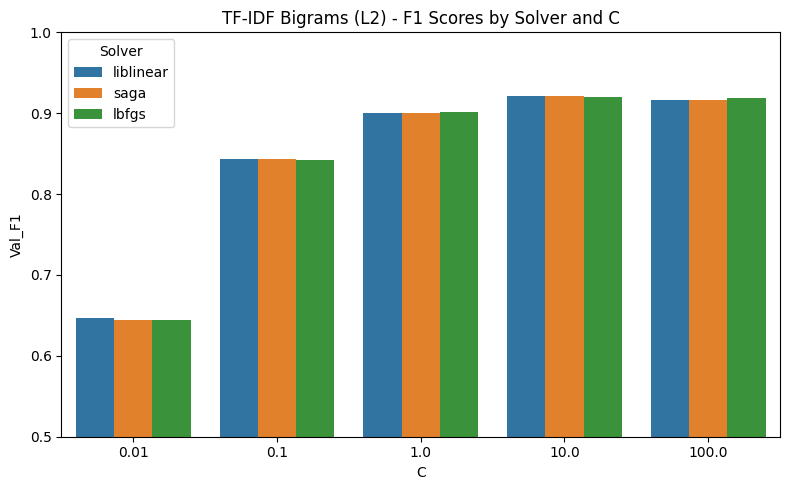

✅ Saved plot to: models/results/plots/f1_bar_TF-IDF_Bigrams.png

🏆 Best Config:
Vectorizer    TF-IDF Bigrams
Solver             liblinear
Penalty                   l2
C                       10.0
Val_F1              0.921535
Name: 3, dtype: object

📈 Test Set Evaluation
              precision    recall  f1-score   support

        Real       0.92      0.95      0.94      3000
        Fake       0.93      0.90      0.92      2395

    accuracy                           0.93      5395
   macro avg       0.93      0.93      0.93      5395
weighted avg       0.93      0.93      0.93      5395

ROC AUC: 0.9765539318023662
🔍 Generating LIME explanation...
✅ LIME saved to: models/results/explain/lime_TF-IDF_Bigrams.html
🔍 Generating SHAP explanation...


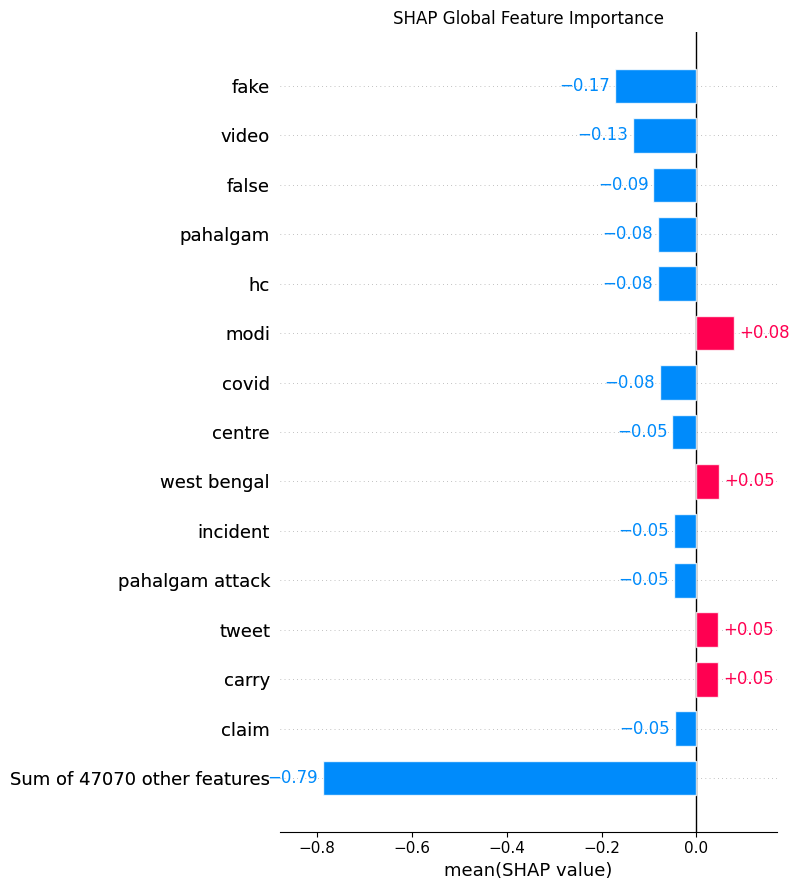

✅ SHAP saved to: models/results/explain/shap_bar_TF-IDF_Bigrams.png

📊 Processing: Char TF-IDF


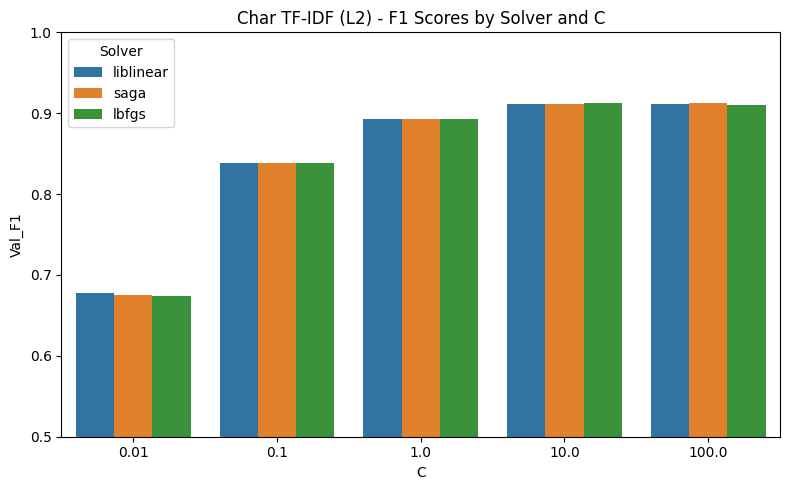

✅ Saved plot to: models/results/plots/f1_bar_Char_TF-IDF.png

🏆 Best Config:
Vectorizer    Char TF-IDF
Solver              lbfgs
Penalty                l2
C                    10.0
Val_F1           0.912755
Name: 13, dtype: object

📈 Test Set Evaluation
              precision    recall  f1-score   support

        Real       0.91      0.95      0.93      3000
        Fake       0.93      0.89      0.91      2395

    accuracy                           0.92      5395
   macro avg       0.92      0.92      0.92      5395
weighted avg       0.92      0.92      0.92      5395

ROC AUC: 0.974154070981211
🔍 Generating LIME explanation...
✅ LIME saved to: models/results/explain/lime_Char_TF-IDF.html
🔍 Generating SHAP explanation...


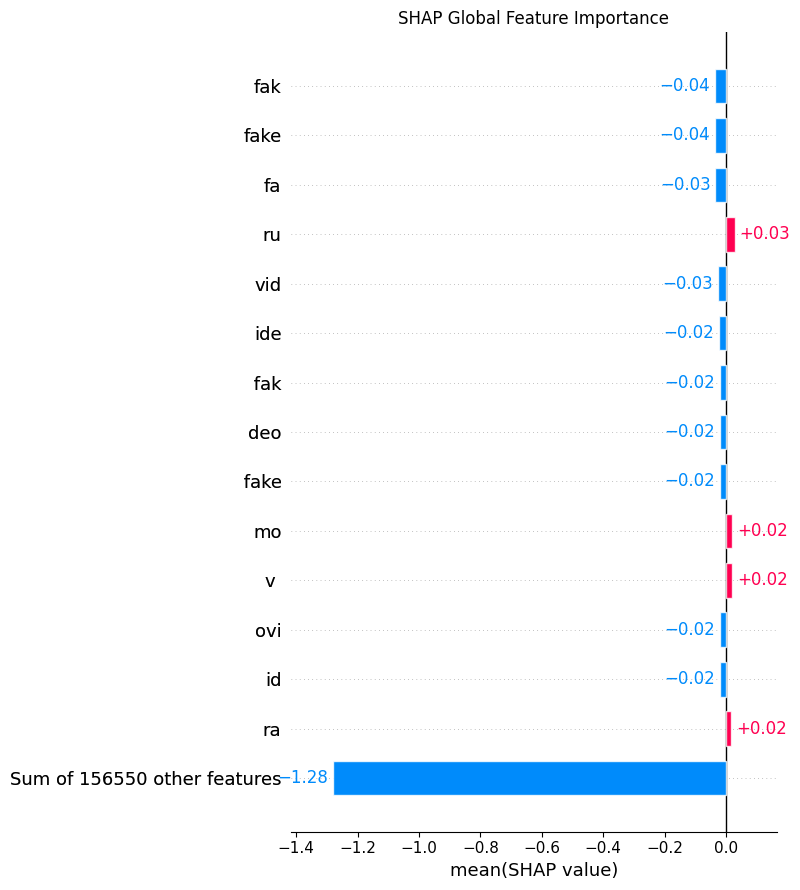

✅ SHAP saved to: models/results/explain/shap_bar_Char_TF-IDF.png


In [7]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from IPython.display import display, HTML
import shap
import lime.lime_text

# Paths
csv_paths = {
    "TF-IDF Bigrams": "models/results/penalty_solver_grid/grid_results_TFIDF_Bigrams_SAFE.csv",
    "Char TF-IDF": "models/results/penalty_solver_grid/grid_results_Char_TFIDF.csv"
}

# Load data
train_df = pd.read_csv("data/processed_train.csv").dropna(subset=["clean_headline"])
val_df = pd.read_csv("data/processed_val.csv").dropna(subset=["clean_headline"])
test_df = pd.read_csv("data/processed_test.csv").dropna(subset=["clean_headline"])

X_trainval = pd.concat([train_df["clean_headline"], val_df["clean_headline"]]).astype(str).reset_index(drop=True)
y_trainval = pd.concat([train_df["label_encoded"], val_df["label_encoded"]]).reset_index(drop=True)
X_test = test_df["clean_headline"].astype(str).reset_index(drop=True)
y_test = test_df["label_encoded"].reset_index(drop=True)

# Vectorizers
vectorizer_configs = {
    "TF-IDF Bigrams": TfidfVectorizer(ngram_range=(1, 2), min_df=2),
    "Char TF-IDF": TfidfVectorizer(analyzer="char", ngram_range=(2, 5), min_df=2)
}

# Output directories
os.makedirs("models/results/plots", exist_ok=True)
os.makedirs("models/results/explain", exist_ok=True)

for name, csv_path in csv_paths.items():
    print(f"\n📊 Processing: {name}")

    # Load CSV and plot
    df = pd.read_csv(csv_path)
    df_plot = df[df["Penalty"] == "l2"]
    
    plt.figure(figsize=(8, 5))
    sns.barplot(data=df_plot, x="C", y="Val_F1", hue="Solver")
    plt.title(f"{name} (L2) - F1 Scores by Solver and C")
    plt.ylim(0.5, 1.0)
    plt.tight_layout()
    plot_path = f"models/results/plots/f1_bar_{name.replace(' ', '_')}.png"
    plt.savefig(plot_path, dpi=300)
    plt.show()
    print(f"✅ Saved plot to: {plot_path}")

    # Extract best config
    best_config = df.sort_values(by="Val_F1", ascending=False).iloc[0]
    print("\n🏆 Best Config:")
    print(best_config)

    # Refit and evaluate on test
    vec = vectorizer_configs[name]
    X_trainval_vec = vec.fit_transform(X_trainval)
    X_test_vec = vec.transform(X_test)

    clf = LogisticRegression(
        C=best_config["C"],
        solver=best_config["Solver"],
        penalty=best_config["Penalty"],
        max_iter=2000
    )
    clf.fit(X_trainval_vec, y_trainval)
    y_pred = clf.predict(X_test_vec)
    y_proba = clf.predict_proba(X_test_vec)[:, 1]

    print("\n📈 Test Set Evaluation")
    print(classification_report(y_test, y_pred, target_names=["Real", "Fake"]))
    print("ROC AUC:", roc_auc_score(y_test, y_proba))

    # 👉 LIME Explainability
    print("🔍 Generating LIME explanation...")
    explainer = lime.lime_text.LimeTextExplainer(class_names=["Real", "Fake"])
    def predict_proba(texts):
        return clf.predict_proba(vec.transform(texts))

    exp = explainer.explain_instance(X_test.iloc[10], predict_proba, num_features=10)
    lime_path = f"models/results/explain/lime_{name.replace(' ', '_')}.html"
    exp.save_to_file(lime_path)
    print(f"✅ LIME saved to: {lime_path}")

    # 👉 SHAP Explanation
    print("🔍 Generating SHAP explanation...")
    explainer_shap = shap.Explainer(clf, X_trainval_vec, feature_names=vec.get_feature_names_out())
    shap_vals = explainer_shap(X_test_vec[:50])

    plt.title("SHAP Global Feature Importance")
    shap.plots.bar(shap_vals.mean(0), max_display=15, show=False)
    plt.tight_layout()
    shap_path = f"models/results/explain/shap_bar_{name.replace(' ', '_')}.png"
    plt.savefig(shap_path, dpi=300)
    plt.show()
    print(f"✅ SHAP saved to: {shap_path}")

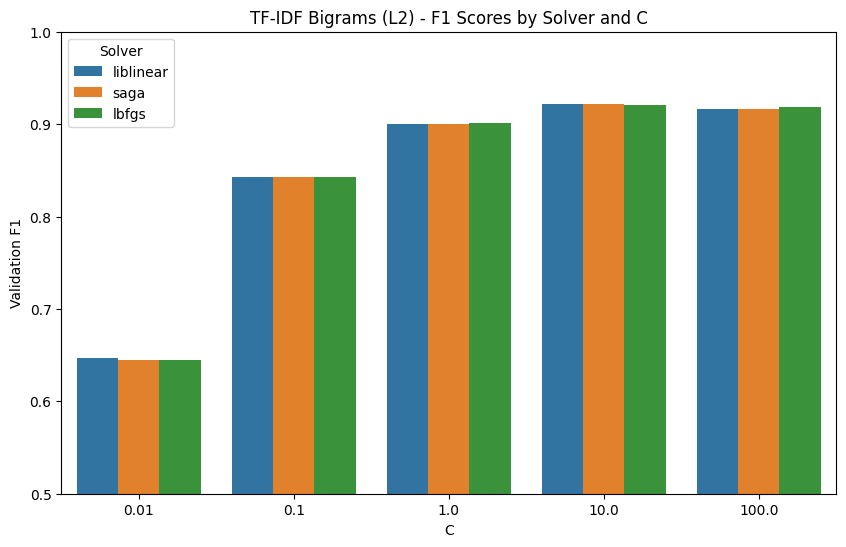

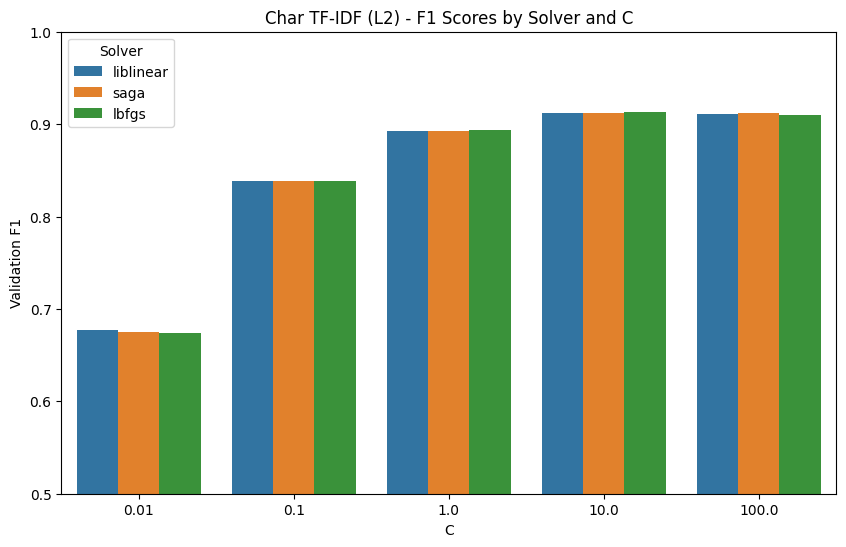

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load result files
df_bi = pd.read_csv("models/results/penalty_solver_grid/grid_results_TFIDF_Bigrams_SAFE.csv")
df_char = pd.read_csv("models/results/penalty_solver_grid/grid_results_Char_TFIDF.csv")

# Common plotting function
def plot_configs(df, title, filename):
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df, x="C", y="Val_F1", hue="Solver")
    plt.title(title)
    plt.ylim(0.5, 1.0)
    plt.ylabel("Validation F1")
    plt.savefig(f"models/results/{filename}.png", dpi=300)
    plt.show()

plot_configs(df_bi[df_bi["Penalty"] == "l2"], "TF-IDF Bigrams (L2) - F1 Scores by Solver and C", "f1_bar_TF-IDF_Bigrams")
plot_configs(df_char[df_char["Penalty"] == "l2"], "Char TF-IDF (L2) - F1 Scores by Solver and C", "f1_bar_Char_TF-IDF")

In [10]:
import pandas as pd
import numpy as np
import os, time, warnings
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

warnings.filterwarnings("ignore")
os.makedirs("models/results/penalty_solver_grid", exist_ok=True)

# 🧼 Load and prepare data
train_df = pd.read_csv("data/processed_train.csv").dropna(subset=["clean_headline"])
val_df = pd.read_csv("data/processed_val.csv").dropna(subset=["clean_headline"])

X_train = train_df["clean_headline"].astype(str).reset_index(drop=True)
y_train = train_df["label_encoded"].reset_index(drop=True)
X_val = val_df["clean_headline"].astype(str).reset_index(drop=True)
y_val = val_df["label_encoded"].reset_index(drop=True)

# 🔀 Vectorizer Ensemble
vec_word = TfidfVectorizer(ngram_range=(1, 2), min_df=2)
vec_char = TfidfVectorizer(analyzer="char", ngram_range=(2, 5), min_df=2)

X_train_word = vec_word.fit_transform(X_train)
X_val_word = vec_word.transform(X_val)

X_train_char = vec_char.fit_transform(X_train)
X_val_char = vec_char.transform(X_val)

X_train_vec = hstack([X_train_word, X_train_char])
X_val_vec = hstack([X_val_word, X_val_char])

print(f"✅ Ensemble Vectorized Shape: {X_train_vec.shape}, Memory: {X_train_vec.data.nbytes / (1024*1024):.2f} MB")

# 🔧 Grid Setup
C_values = [0.01, 0.1, 1, 10, 100]
solvers = ["liblinear", "saga", "lbfgs"]
penalty = "l2"
results = []

# 🔄 Grid Search
for solver in solvers:
    for C in C_values:
        try:
            print(f"\n🔧 Config: solver={solver}, C={C}")
            start = time.time()
            clf = LogisticRegression(C=C, solver=solver, penalty=penalty, max_iter=2000)
            clf.fit(X_train_vec, y_train)
            f1 = f1_score(y_val, clf.predict(X_val_vec))
            elapsed = time.time() - start
            print(f"✅ F1 Score: {f1:.4f} | Time: {elapsed:.2f}s")
            results.append(("TFIDF_BiChar_Ensemble", solver, penalty, C, f1))
        except Exception as e:
            print("❌ Error:", e)
            continue

# 💾 Save
df_results = pd.DataFrame(results, columns=["Vectorizer", "Solver", "Penalty", "C", "Val_F1"])
df_results.to_csv("models/results/penalty_solver_grid/grid_results_TFIDF_BiChar_Ensemble.csv", index=False)
print("\n📁 Saved to: grid_results_TFIDF_BiChar_Ensemble.csv")

✅ Ensemble Vectorized Shape: (43157, 191196), Memory: 58.14 MB

🔧 Config: solver=liblinear, C=0.01
✅ F1 Score: 0.7648 | Time: 0.45s

🔧 Config: solver=liblinear, C=0.1
✅ F1 Score: 0.8684 | Time: 0.98s

🔧 Config: solver=liblinear, C=1
✅ F1 Score: 0.9139 | Time: 1.54s

🔧 Config: solver=liblinear, C=10
✅ F1 Score: 0.9240 | Time: 2.29s

🔧 Config: solver=liblinear, C=100
✅ F1 Score: 0.9230 | Time: 2.57s

🔧 Config: solver=saga, C=0.01
✅ F1 Score: 0.7626 | Time: 1.08s

🔧 Config: solver=saga, C=0.1
✅ F1 Score: 0.8686 | Time: 1.09s

🔧 Config: solver=saga, C=1
✅ F1 Score: 0.9139 | Time: 1.24s

🔧 Config: solver=saga, C=10
✅ F1 Score: 0.9238 | Time: 4.20s

🔧 Config: solver=saga, C=100
✅ F1 Score: 0.9234 | Time: 15.89s

🔧 Config: solver=lbfgs, C=0.01
✅ F1 Score: 0.7629 | Time: 0.47s

🔧 Config: solver=lbfgs, C=0.1
✅ F1 Score: 0.8687 | Time: 1.01s

🔧 Config: solver=lbfgs, C=1
✅ F1 Score: 0.9139 | Time: 0.99s

🔧 Config: solver=lbfgs, C=10
✅ F1 Score: 0.9226 | Time: 0.95s

🔧 Config: solver=lbfgs, C=100


✅ Classification report saved.


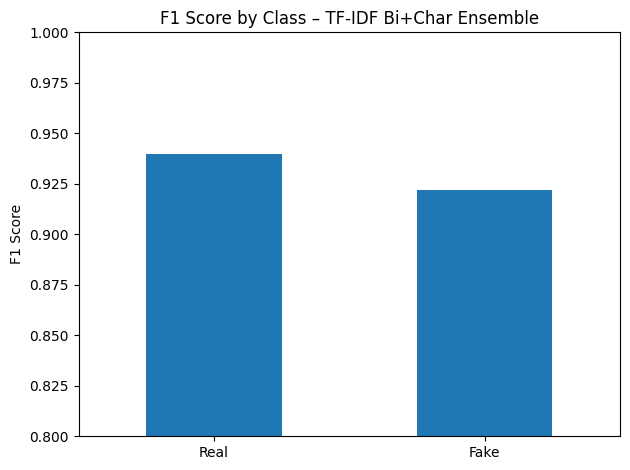

✅ F1 bar plot saved.


In [11]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from scipy.sparse import hstack
import joblib

# 📁 Paths
os.makedirs("models/results/ensemble", exist_ok=True)
os.makedirs("models/plots", exist_ok=True)

# 📄 Load data
train_df = pd.read_csv("data/processed_train.csv").dropna(subset=["clean_headline"])
val_df = pd.read_csv("data/processed_val.csv").dropna(subset=["clean_headline"])
test_df = pd.read_csv("data/processed_test.csv").dropna(subset=["clean_headline"])

X_trainval = pd.concat([train_df["clean_headline"], val_df["clean_headline"]]).astype(str).reset_index(drop=True)
y_trainval = pd.concat([train_df["label_encoded"], val_df["label_encoded"]]).reset_index(drop=True)
X_test = test_df["clean_headline"].astype(str).reset_index(drop=True)
y_test = test_df["label_encoded"].reset_index(drop=True)

# 🔠 Create and fit both vectorizers
vec_bigram = TfidfVectorizer(ngram_range=(1, 2), min_df=2)
vec_char = TfidfVectorizer(analyzer="char", ngram_range=(2, 5), min_df=2)

X_trainval_vec = hstack([vec_bigram.fit_transform(X_trainval),
                         vec_char.fit_transform(X_trainval)])

X_test_vec = hstack([vec_bigram.transform(X_test),
                     vec_char.transform(X_test)])

# 🧠 Train model with best config
clf = LogisticRegression(C=10, solver="liblinear", penalty="l2", max_iter=2000)
clf.fit(X_trainval_vec, y_trainval)

# 📊 Predict and save classification report
y_pred = clf.predict(X_test_vec)
report = classification_report(y_test, y_pred, target_names=["Real", "Fake"], output_dict=True)

df_report = pd.DataFrame(report).transpose()
df_report.to_csv("models/results/ensemble/test_classification_report_TFIDF_BiChar.csv")
print("✅ Classification report saved.")

# 📈 Plot F1 scores
f1_scores = df_report.loc[["Real", "Fake"], "f1-score"]
f1_scores.plot(kind="bar", title="F1 Score by Class – TF-IDF Bi+Char Ensemble")
plt.ylabel("F1 Score")
plt.ylim(0.8, 1.0)
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("models/plots/f1_bar_BiChar_ensemble.png", dpi=300)
plt.show()
print("✅ F1 bar plot saved.")

In [12]:
import lime
import lime.lime_text
from IPython.display import display, HTML

explainer = lime.lime_text.LimeTextExplainer(class_names=["Real", "Fake"])

def predict_proba(texts):
    return clf.predict_proba(hstack([
        vec_bigram.transform(texts),
        vec_char.transform(texts)
    ]))

idx = 10  # or any index you'd like
exp = explainer.explain_instance(X_test.iloc[idx], predict_proba, num_features=10)

# Display and Save
display(HTML(exp.as_html()))
lime_path = "models/results/ensemble/lime_TFIDF_BiChar.html"
exp.save_to_file(lime_path)
print(f"✅ LIME explanation saved to: {lime_path}")

✅ LIME explanation saved to: models/results/ensemble/lime_TFIDF_BiChar.html


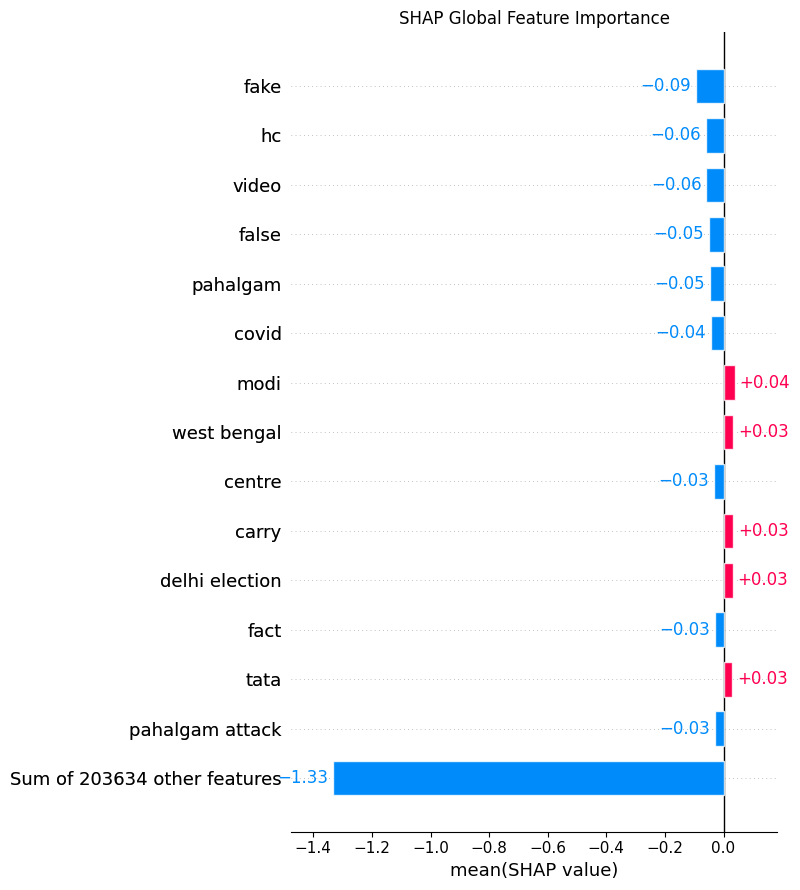

✅ SHAP bar plot saved.


In [13]:
import shap
import matplotlib.pyplot as plt

# SHAP with sparse matrix support
explainer_shap = shap.Explainer(clf, X_trainval_vec, feature_names=(vec_bigram.get_feature_names_out().tolist() + vec_char.get_feature_names_out().tolist()))
shap_values = explainer_shap(X_test_vec[:50])

# Plot and Save
plt.title("SHAP Global Feature Importance")
shap.plots.bar(shap_values.mean(0), max_display=15, show=False)
plt.tight_layout()
plt.savefig("models/results/ensemble/shap_bar_TFIDF_BiChar.png", dpi=300)
plt.show()
print("✅ SHAP bar plot saved.")